# Fitting of EPR Spectra with MarS

This notebook demonstrates how to use the Mars library to fit experimental EPR spectra by optimizing Hamiltonian (or other) parameters.

Mars provides integration with powerful optimization libraries (Optuna and Nevergrad) that implement various algorithms with different strengths for finding global minima in complex parameter spaces.


\
\
\
\
\
\
For any questions, please contact Arkady Samsonenko via: \
Telegram: @Arkady_Samsonenko \
Email: a.samsonenko.tomo.nsc.ru

In [1]:
# Import necessary libraries
import sys
import os
import math
from importlib import reload

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import optuna
import nevergrad as ng

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
# Import Mars library components
import mars
from mars import spin_system, spectra_manager, mesher, constants
from mars import utils

Some stuff might fail: issue in joblib



## 1. Introduction to EPR Spectral Fitting
Fitting EPR spectra involves finding the optimal set of spin Hamiltonian parameters that reproduce experimental data. For complex systems with multiple interacting spins, this becomes a challenging non-linear optimization problem with many parameters.

Mars provides a flexible framework for this task by integrating state-of-the-art optimization algorithms. The workflow involves:
1. Defining a parameterized spin system model
2. Creating a parameter space with appropriate bounds
3. Setting up an objective function (for example, mean squared error)
4. Running optimization with different algorithms
5. Analyzing best-fit parameters and spectra

Key optimization strategies we'll explore:
- **Tree-structured Parzen Estimator optimization** (via Optuna's TPE): Good for initial exploration of parameter space. 
- **Evolutionary strategies** (CMA-ES): Efficient at converging to local minima
- **Gradient-free optimization** (Cobyla): Fast convergence when starting near a solution
- **Hybrid approaches**: Combining methods for robust fitting

# 2. Generating Synthetic Data for Demonstration

Let's start by generating two synthetic EPR spectra that we'll later try to fit.

We create spectra with the same g-tensor parameters and different zero field splitting

In [2]:
dtype = torch.float64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

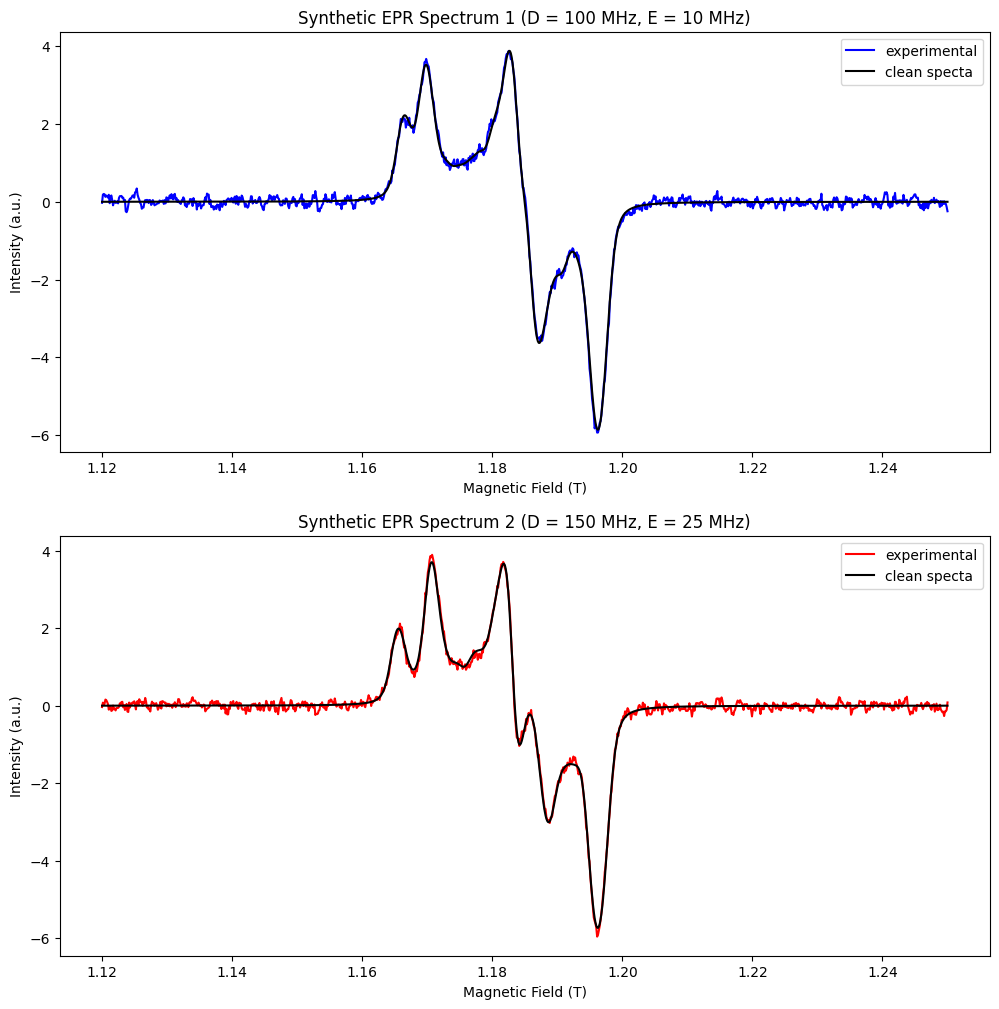

In [3]:
def generate_synthetic_spectrum(g_tensor_values, dipolar_D, dipolar_E, temperature=10.0):
    """
    Generate a synthetic spectrum with specified parameters
    
    Parameters:
    -----------
    g_tensor_values : tuple
        Principal values of the g-tensor (gx, gy, gz)
    dipolar_D, dipolar_E : float
        Zero-field splitting parameters D and E (in Hz)
    temperature : float
        Temperature in Kelvin (default: 10.0 K)
        
    Returns:
    --------
    fields : numpy.ndarray
        Magnetic field values in Tesla
    spectrum_smooth : numpy.ndarray 
        Simulated spectrum with added noise and smoothing
    spectrum_clean : numpy.ndarray 
        Simulated spectrum without distortions
     """
    
    # Create parameterized spin system
    g_tensor = spin_system.Interaction(g_tensor_values, dtype=dtype, device=device)
    dipolar_interaction = spin_system.DEInteraction([dipolar_D, dipolar_E], dtype=dtype, device=device)
    
    system = spin_system.SpinSystem(
        electrons=[0.5, 0.5],
        g_tensors=[g_tensor, g_tensor],
        electron_electron=[(0, 1, dipolar_interaction)],
        dtype=dtype,
        device=device
    )
    
    sample = spin_system.MultiOrientedSample(
        spin_system=system,
        ham_strain=5e7,
        gauss=0.001,
        lorentz=0.001,
        dtype=dtype,
        device=device
    )
    
    # Create spectra at Q-band frequency
    freq = 34e9  # 34 GHz
    fields = torch.linspace(1.12, 1.25, 1000, dtype=dtype, device=device)
    
    # Create spectrum
    spectra_creator = spectra_manager.StationarySpectra(
        freq=freq, 
        sample=sample,
        temperature=temperature,
        dtype=dtype,
        device=device
    )
    
    spectrum = spectra_creator(sample, fields)
    
    
    # Apply distrotions to make it more realistic
    # Noize + smooth + Noize
    noise = torch.normal(mean=0.0, std=0.03 * spectrum.abs().max(), size=spectrum.shape, device=device, dtype=dtype)
    spectrum_noisy = spectrum + noise
    
    spectrum_smooth = torch.tensor(
        savgol_filter(spectrum_noisy.cpu().numpy(), window_length=11, polyorder=2),
        device=device, dtype=dtype
    )
    noise = torch.normal(mean=0.0, std=0.01 * spectrum.abs().max(), size=spectrum.shape, device=device, dtype=dtype)
    spectrum_smooth = spectrum_smooth + noise
    

    return fields.cpu().numpy(), spectrum_smooth.cpu().numpy(), spectrum.cpu().numpy()


# Generate two synthetic spectra with different parameters
# They have the similar g-tensors but different D-E parameters
fields1, spectrum1, spectrum_clean1 = generate_synthetic_spectrum(
    g_tensor_values=(2.03, 2.05, 2.08),
    dipolar_D=100e6,  # 100 MHz
    dipolar_E=10e6,   # 10 MHz
    temperature=10.0
)

fields2, spectrum2, spectrum_clean2 = generate_synthetic_spectrum(
    g_tensor_values=(2.03, 2.05, 2.08), # Set the same as previous
    dipolar_D=150e6,  # 150 MHz
    dipolar_E=25e6,   # 25 MHz
    temperature=10.0
)

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(fields1, spectrum1, 'b-', linewidth=1.5, label="experimental")
plt.plot(fields1, spectrum_clean1, 'black', linewidth=1.5, label="clean specta")
plt.title('Synthetic EPR Spectrum 1 (D = 100 MHz, E = 10 MHz)', fontsize=12)
plt.xlabel('Magnetic Field (T)', fontsize=10)
plt.ylabel('Intensity (a.u.)', fontsize=10)
plt.legend()
plt.subplot(2, 1, 2)

plt.plot(fields2, spectrum2, 'r-', linewidth=1.5, label="experimental")
plt.plot(fields1, spectrum_clean2, 'black', linewidth=1.5, label="clean specta")
plt.title('Synthetic EPR Spectrum 2 (D = 150 MHz, E = 25 MHz)', fontsize=12)
plt.xlabel('Magnetic Field (T)', fontsize=10)
plt.ylabel('Intensity (a.u.)', fontsize=10)

plt.legend()

plt.show()

# 3. Setting Up the Parameter Space for Optimization
In this unit we create the optimization space and consider its possibilities 

We will define:

1. **g-tensor components** (gx, gy, gz):
2. **Zero-field splitting parameters** (D, E):
3. **Line broadening parameters**: Hamiltonian strain and Lorentzian width

For our simple spectra it can be overkill but we want to consider how different methods find results

In [4]:
from mars.optimization import ParameterSpace, ParamSpec, SpectrumFitter, SpaceSearcher, print_trial_results

[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


### 3.1 Creation of Parameter to optimize
Let's create single parameter to optimize and consider its possible paramerters

In [5]:
gz = ParamSpec(name="gz", bounds=(2.0, 2.2), default=2.05)

# Sometimes, when it is necessary to evaluate the influence of various parameters, it is advisable to fix this parameter.
gz = ParamSpec(name="gz", bounds=(2.0, 2.2), default=2.05, vary=False) # In this case the default value will be used

Here we created one single parameter that will be optimized. It takes:
 
1) Name
2) Bounds of variation
3) Default value

This parameter is part of parameter space. Let's create this space

### 3.2 Creation of Optimization Space
Let's create the parameter space:

In [6]:
param_specs = [
    # g-tensor components
    ParamSpec(name="gz", bounds=(2.0, 2.10), default=2.05, vary=True),
    ParamSpec(name="gx", bounds=(2.0, 2.06), default=2.05, vary=True),
    ParamSpec(name="gy", bounds=(2.0, 2.06), default=2.05, vary=True),
    
    # Dipolar coupling parameters
    ParamSpec(name="D", bounds=(50e6, 200e6), default=100e6, vary=True),  # 50-200 MHz
    ParamSpec(name="E", bounds=(5e6, 40e6), default=10e6, vary=True),    # 5-40 MHz
    
    # Hamiltonian strain
    ParamSpec(name="ham_strain", bounds=(2e7, 1e8), default=5e7, vary=True),
    
    # Set only Lorentz, since gauss with ham_strain is overfit
    ParamSpec(name="lorentz", bounds=(0.0, 1e-3), default=1e-4, vary=True)
]  # Create the list of varied parameters


# Create parameter space with fixed parameters
param_space = ParameterSpace(
    specs=param_specs,
    fixed_params={"temperature": 10.0, "freq": 34e9}
)  # parameter space consist of: varing parameters and fixed_parameters

In [7]:
print(param_space) # Display parameter space configuration

____Fixed parameters_____ 
----------------------------------------
  temperature =         10.0000
  freq        =        3.40e+10


______Varying parameters_____ 
----------------------------------------
  gz         =          2.0500   (low:   +2.0000  up:   +2.1000)
  gx         =          2.0500   (low:   +2.0000  up:   +2.0600)
  gy         =          2.0500   (low:   +2.0000  up:   +2.0600)
  D          =        1.00e+08   (low:   +5.00e+07  up:   +2.00e+08)
  E          =        1.00e+07   (low:   +5.00e+06  up:   +4.00e+07)
  ham_strain =        5.00e+07   (low:   +2.00e+07  up:   +1.00e+08)
  lorentz    =          0.0001   (low:   +0.0000  up:   +0.0010)



Let's create function that get's parameters and returns sample

In [8]:
def create_sample(params: dict):
    """Create sample with new parameters"""
    # Create g-tensor with given parameters
    g_tensor = spin_system.Interaction(
        (params["gx"], params["gy"], params["gz"]), 
        dtype=dtype, 
        device=device
    )
    
    # Create dipolar interaction
    dipolar_interaction = spin_system.DEInteraction(
        [params["D"], params["E"]],
        dtype=dtype,
        device=device
    )
    
    # Create spin system
    system = spin_system.SpinSystem(
        electrons=[0.5, 0.5],
        g_tensors=[g_tensor, g_tensor],
        electron_electron=[(0, 1, dipolar_interaction)],
        dtype=dtype,
        device=device
    )
    
    # Create sample
    sample = spin_system.MultiOrientedSample(
        spin_system=system,
        ham_strain=params["ham_strain"],
        lorentz=params["lorentz"],
        dtype=dtype,
        device=device
    )
    return sample


sample_default = create_sample(param_space)
print(sample_default)

SPIN SYSTEM SUMMARY

PARTICLES:
--------------------
Electrons (2):
  e0: S=0.5 
Principal values: [2.0500, 2.0500, 2.0500]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  e1: S=0.5 
Principal values: [2.0500, 2.0500, 2.0500]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None

Nuclei: None

SYSTEM PROPERTIES:
--------------------
Hilbert space dimension: 4
Configuration shape: ()

INTERACTIONS (1 total):
------------------------------

Electron-Electron (1):
  1. e0 ↔ e1:
      Principal values: [-2.33e+07, -4.33e+07, 6.67e+07]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None


GENERAL INFO: 
lorentz: 0.00010 T
gauss: 0.00000 T
ham_str: ['5.0000e+07', '5.0000e+07', '5.0000e+07'] Hz


# 4. Fitting procedures

### 4.1 Creating Spectra Simulator

We need a callable object that generates spectra based on optimization parameters. This simulator will be used by the optimizer to evaluate different parameter sets. You can create 

In [9]:
class CWSpectraSimulator:
    def __call__(self, fields, params): # It takes Two parameters: fields and params from param_space
        """
        Generate a spectrum for given magnetic fields and parameters
        Parameters:
        -----------
        fields : torch.Tensor
            Magnetic field values in Tesla
        params : dict
            Parameter dictionary from the parameter space

        Returns:
        --------
        spectrum : torch.Tensor
            Simulated EPR spectrum
        """
        sample = create_sample(params) # Create sample with current parameters
        
        spectra_creator = spectra_manager.StationarySpectra(freq=params["freq"], sample=sample, temperature=params["temperature"], device=device, dtype=dtype)
        spectrum = spectra_creator(sample, fields) # Generate and return the spectrum
        
        return spectrum

### 4.2 Fitter creation

Now we create the SpectrumFitter object that will handle the optimization process. By default, it uses Mean Squared Error (MSE) as the objective function, but other metrics like correlation or cosine similarity can also be used.

In [10]:
fitter1 = SpectrumFitter(
    x_exp=fields1, # Experimental field values
    y_exp=spectrum1, # Experimental spectrum intensities
    param_space=param_space, # Parameter space defined earlier
    spectra_simulator=CWSpectraSimulator(),
    norm_mode="max",  # Normalize by maximum intensity
    device=device
)

# 5. Fitting methods


MarS integrates with two powerful optimization libraries:

1) **Optuna [1]**: Optuna has few optimization methods. However, it utilizes some of the most important and interesting ones. It also has its own capabilities for parameter space exploration.

Tree-structured Parzen Estimator (TPE): Good for global exploration
CMA-ES: Efficient evolutionary strategy for local refinement


1.1) Bayseian optimization: This method is very time-consuming, but requires the fewest number of steps. Furthermore, it provides a controlled balance between exploration and exploitation. \ 
If the calculation time for a single spectrum is long (more than 2-10 seconds), it is better to use this method.

1.2) TPE (Tree-structured Parzen Estimator). This method has the powerfull exploration and can be used not only to get the best fit result but also to discover optimization space. 

1.3) CmaEs. This is evolution-based stratagy

1.4) Other methods that can be found in docs of Optuna [https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.CmaEsSampler.html#optuna.samplers.CmaEsSampler]


2) **Nevergrad** [2]. Nevergrad provides 400+ optimization algorithms from various families.

Today we consider onlly one of them:
COBYLA: Constraint Optimization BY Linear Approximations


[1] Akiba et al., "Optuna: A Next-generation Hyperparameter Optimization Framework", KDD 2019
[2] Rapin & Teytaud, "Nevergrad - A Python toolbox for performing gradient-free optimization", 2018

In [ ]:
SpectrumFitter.__available_optimizer__   # can print all avaliable optimizaers

### 5.1. Optuna fitting with TPE

We start from TPE (Tree-structured Parzen Estimator). TPE is a Bayesian optimization method that balances exploration and exploitation. It's particularly useful for initial exploration of complex parameter spaces. It is introducaed via optuna backend.

We'll also explore using the Optuna dashboard. You can learn more about its capabilities at: https://optuna-dashboard.readthedocs.io/en/stable/getting-started.html

In [ ]:
result_TPE = fitter1.fit(backend="optuna", n_trials=300, run_dashboard=True, study_name="test_study_TPE")
# Optuna with TPE is default method, We also run dash board to study it

The Optuna-dashboard is now opened. Just search it yourself; it's quite intuitive.

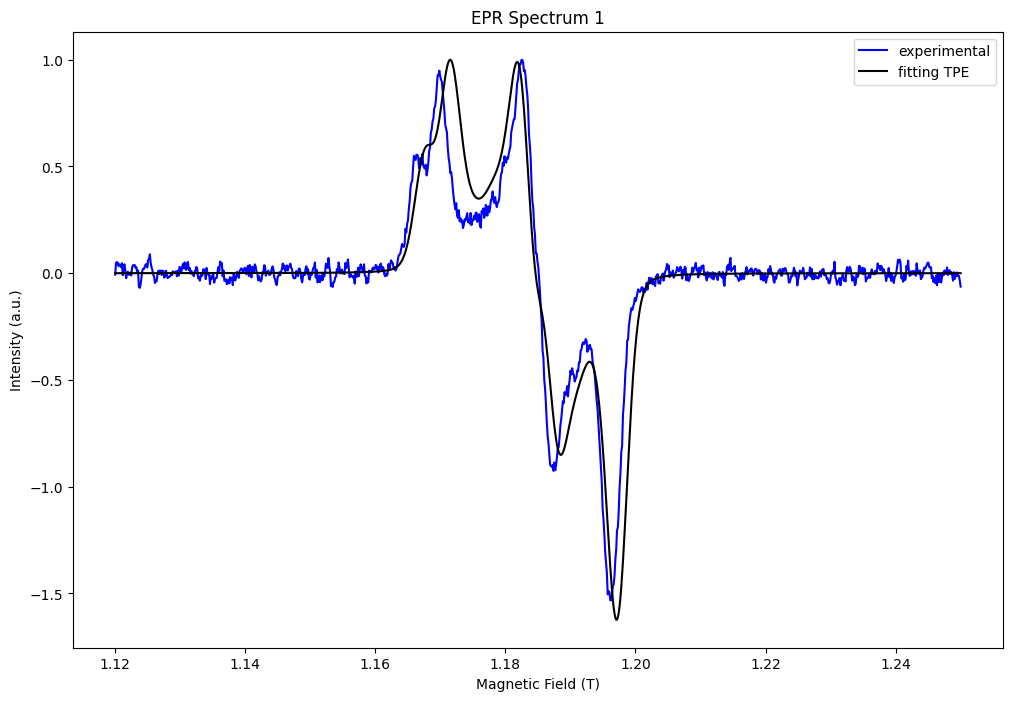

In [13]:
plt.figure(figsize=(12, 8))

plt.plot(fields1, spectrum1 / max(spectrum1), 'b-', linewidth=1.5, label="experimental")
plt.plot(fields1, result_TPE.best_spectrum.numpy() / max(result_TPE.best_spectrum.numpy()), 'black', linewidth=1.5, label="fitting TPE")
plt.title('EPR Spectrum 1', fontsize=12)
plt.xlabel('Magnetic Field (T)', fontsize=10)
plt.ylabel('Intensity (a.u.)', fontsize=10)
plt.legend()

The TPE algorithm provides good exploration of the parameter space but may not efficiently converge to the exact minimum. It helps identify promising regions but often requires refinement with other methods.

### 5.2. Optuna fitting with CMA-ES

The full list of Optaina optimizers are given at https://optuna.readthedocs.io/en/stable/reference/samplers/index.html.

Here we try to use CmaEsSampler. CMA-ES (Covariance Matrix Adaptation Evolution Strategy) is an evolutionary algorithm that efficiently converges to local minima.

In [14]:
sampler = optuna.samplers.CmaEsSampler(
                seed=42,
                n_startup_trials=50,
                restart_strategy="ipop")  # You can define sampler of optuna

result_CmaEs = fitter1.fit(backend="optuna", n_trials=300, run_dashboard=False, study_name="test_study_CmaEs", sampler=sampler)
# Optuna with CmaEsSampler is better to find minima than TPE, but it doen't allow so deep exploaraion as TPE

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``restart_strategy`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

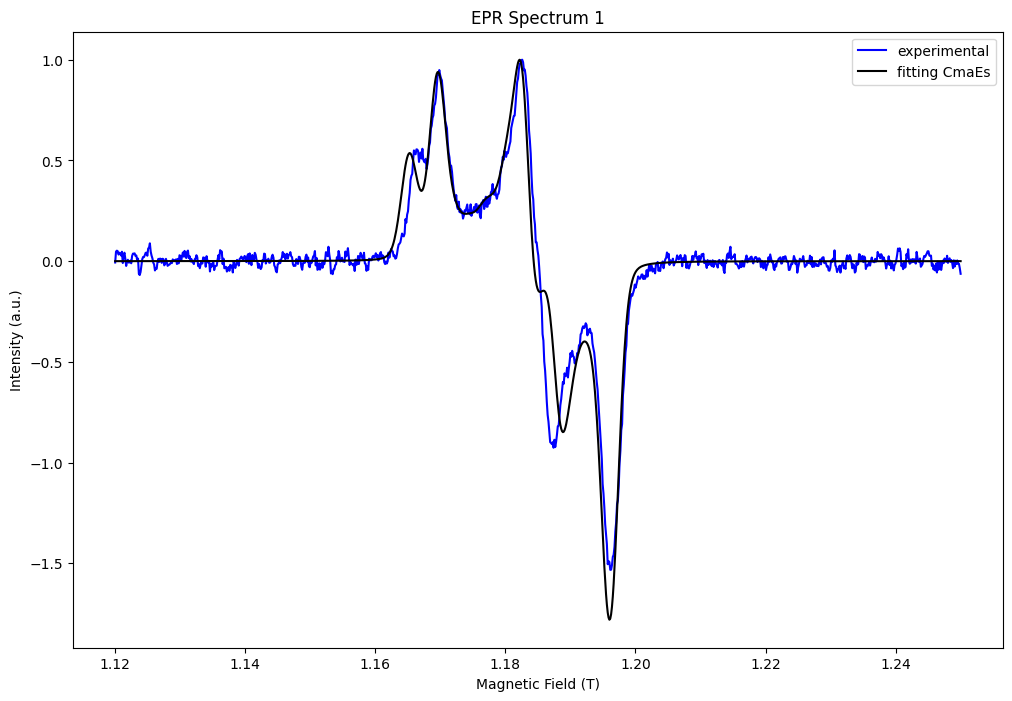

In [15]:
plt.figure(figsize=(12, 8))

plt.plot(fields1, spectrum1 / max(spectrum1), 'b-', linewidth=1.5, label="experimental")
plt.plot(fields1, result_CmaEs.best_spectrum.numpy() / max(result_CmaEs.best_spectrum.numpy()), 'black', linewidth=1.5, label="fitting CmaEs")
plt.title('EPR Spectrum 1', fontsize=12)
plt.xlabel('Magnetic Field (T)', fontsize=10)
plt.ylabel('Intensity (a.u.)', fontsize=10)
plt.legend()

CMA-ES typically converges faster to local minima than TPE but may miss global minima if the initial parameter space is too wide.

### 5.3 Nevergrad with COBYLA Optimizer

Now let's try to use COBYLA fitting method from Nevergrad. COBYLA (Constrained Optimization BY Linear Approximations) is a derivative-free optimization method that's efficient for local refinement when starting near a solution.

In [ ]:
result_Cobyla = fitter1.fit(backend="ng", budget=300, optimizer_name="Cobyla")  # Note, Nevergrad and Optuna naming is different. Be careful with it

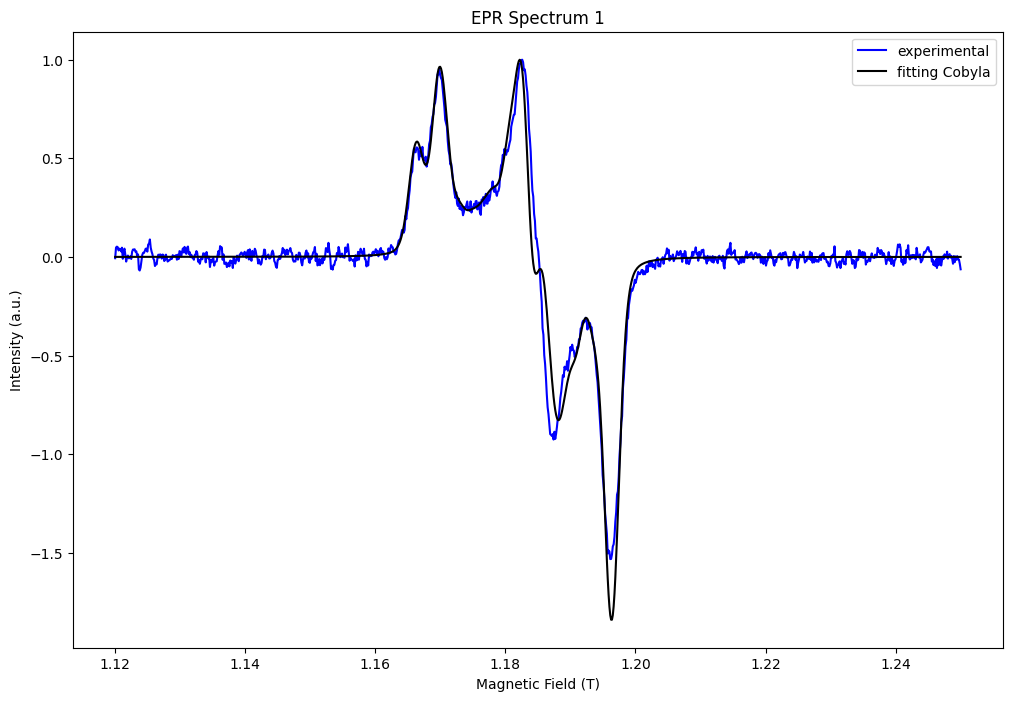

In [17]:
plt.figure(figsize=(12, 8))

plt.plot(fields1, spectrum1 / max(spectrum1), 'b-', linewidth=1.5, label="experimental")
plt.plot(fields1, result_Cobyla.best_spectrum.numpy() / max(result_Cobyla.best_spectrum.numpy()), 'black', linewidth=1.5, label="fitting Cobyla")
plt.title('EPR Spectrum 1', fontsize=12)
plt.xlabel('Magnetic Field (T)', fontsize=10)
plt.ylabel('Intensity (a.u.)', fontsize=10)
plt.legend()

COBYLA works well when starting near a solution but can struggle with global optimization. It's best used after initial exploration with methods like TPE.

### 5.4. Hybrid Optimization Strategy

The good solution is combining different methods to find the best result.

**Let's try to do next steps:**

1) Use TPE for initial global exploration

2) Refine the parameter space bounds based on promising regions

3) Use CMA-ES or COBYLA for fast local convergence

In [22]:
# Run TPE again
result_TPE = fitter1.fit(backend="optuna", n_trials=300, run_dashboard=False, study_name="test_study_TPE") 
best_params_TPE = result_TPE.best_params

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

We then consider what we can do with our current results and update the parameter space.

In [23]:
updated_param_space = param_space.copy()

updated_param_space.set_bounds({"gx": (2.0, 2.1)})  # We can set new bounds
updated_param_space.set_default(best_params_TPE)  # Update default values to the best parameters found by TPE
updated_param_space.reduce_bounds(alpha=0.4) # Reduce bounds to focus on promising region (40% of original width)


# Let's observe how the parameter space has changed
fitter1.param_space = updated_param_space
fitter1.param_space

____Fixed parameters_____ 
----------------------------------------
  temperature =         10.0000
  freq        =        3.40e+10


______Varying parameters_____ 
----------------------------------------
  gz         =          2.0790   (low:   +2.0390  up:   +2.1190)
  gx         =          2.0307   (low:   +1.9907  up:   +2.0707)
  gy         =          2.0498   (low:   +2.0258  up:   +2.0738)
  D          =        8.60e+07   (low:   +2.60e+07  up:   +1.46e+08)
  E          =        2.83e+06   (low:   -1.12e+07  up:   +1.68e+07)
  ham_strain =        8.15e+07   (low:   +4.95e+07  up:   +1.14e+08)
  lorentz    =          0.0001   (low:   -0.0003  up:   +0.0005)

In [ ]:
result_continue = fitter1.fit(backend="ng", budget=300, optimizer_name="Cobyla") 

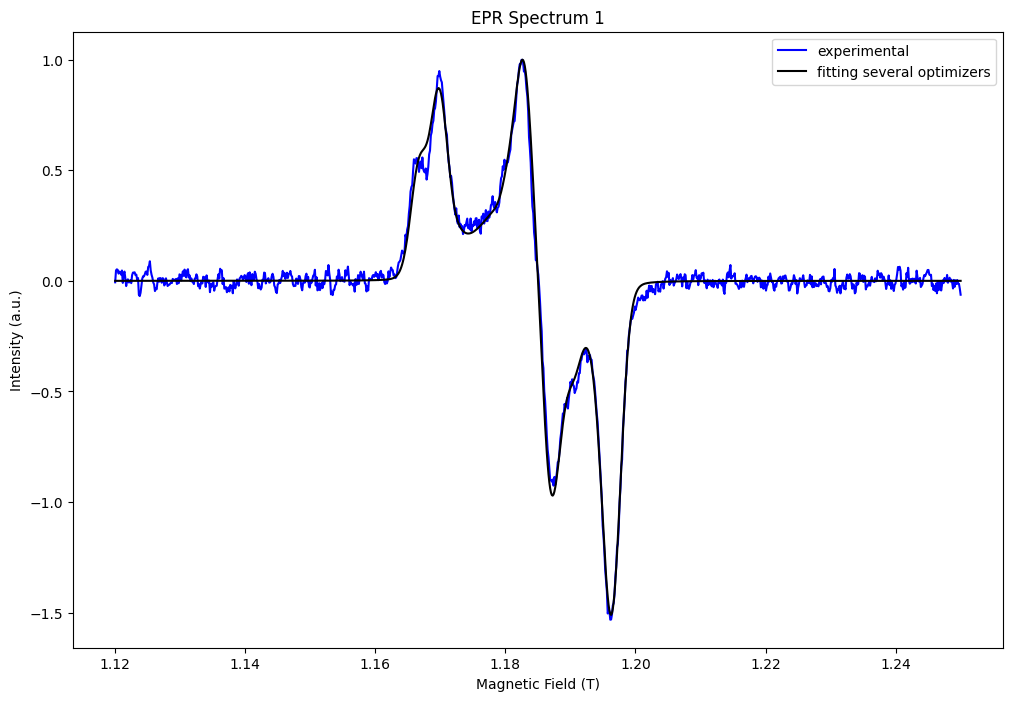

In [25]:
plt.figure(figsize=(12, 8))

plt.plot(fields1, spectrum1 / max(spectrum1), 'b-', linewidth=1.5, label="experimental")
plt.plot(fields1, result_continue.best_spectrum.numpy() / max(result_continue.best_spectrum.numpy()), 'black', linewidth=1.5, label="fitting several optimizers")
plt.title('EPR Spectrum 1', fontsize=12)
plt.xlabel('Magnetic Field (T)', fontsize=10)
plt.ylabel('Intensity (a.u.)', fontsize=10)
plt.legend()

Probably, it is the best result. The hybrid approach typically yields the best results by combining global exploration with local refinement.

### 5.5 Exploring Parameter Space After Optimization
Sometimes multiple local minima exist in complex optimization problems. Mars provides tools to identify alternative solutions that might be physically meaningful.

In [27]:
# Run TPE again
fitter1.param_space = param_space
result_TPE= fitter1.fit(backend="optuna", n_trials=500, run_dashboard=False, study_name="test_study_TPE")

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
searcher = SpaceSearcher()  # Here we create a new instance-Space Searcher. It has some capabilities for searching for other local minima, if they exist.

The space searcher identifies alternative parameter sets with similar loss values but different parameter combinations. This is particularly useful when certain parameters (like g-tensor components) are correlated or when multiple physically meaningful solutions exist.

In [29]:
searche_results = searcher(fit_result=result_CmaEs, param_names=["gx", "gy", "gz"]) 

# set param_names which defines subspace in which new solutions should be found

In [30]:
print_trial_results(searche_results)  # print_trial_results allows to print the parameters in convinient way.

#1) Loss means the same as for optimization.
#2) Distance is the distance between the best-fit parameters and the given parameters. This distance is calculated only for param_names.

TRIAL #243
index: 0
----------------------------------------
Loss:     0.140375
Distance: 0.160760

PARAMETERS:
----------------------------------------
  gz         =        2.084335 (Δ +0.003064)
  gx         =        2.030110 (Δ -0.000378)
  gy         =        2.049688 (Δ +0.000322)
  D          =      1.4201e+08 (Δ +1.3648e+07)
  E          =      2.1160e+07 (Δ -4.8468e+06)
  ham_strain =      6.5839e+07 (Δ -8.2575e+06)
  lorentz    =        0.000384 (Δ -0.000061)


TRIAL #276
index: 1
----------------------------------------
Loss:     0.149576
Distance: 0.143423

PARAMETERS:
----------------------------------------
  gz         =        2.084035 (Δ +0.002764)
  gx         =        2.030128 (Δ -0.000360)
  gy         =        2.049337 (Δ -0.000029)
  D          =      1.3013e+08 (Δ +1.7715e+06)
  E          =      2.5974e+07 (Δ -33407.577277)
  ham_strain =      6.4039e+07 (Δ -1.0058e+07)
  lorentz    =        0.000483 (Δ +0.000038)


TRIAL #266
index: 2
--------------------------

Δ shows the change of parameter compared to the best parameter

As it is expected the results are not stable relative to g-tensor parameters which you also observed in dashboard

# 6. Multi Spectra Fitting

MarS allows to find parameters for set of spectra fitting them simultaniously. Let's do it.

We already have two spectra with identical g-tensors and different zero-field splitting parameters. Let's determine the parameter sapce for fitting them.

In [31]:
param_specs = [
    # Shared g-tensor components
    ParamSpec(name="gz", bounds=(2.0, 2.10), default=2.05, vary=True),
    ParamSpec(name="gx", bounds=(2.0, 2.06), default=2.05, vary=True),
    ParamSpec(name="gy", bounds=(2.0, 2.06), default=2.05, vary=True),
    
    # Dipolar coupling parameters fot first spectra
    ParamSpec(name="D1", bounds=(50e6, 250e6), default=100e6, vary=True),  # 50-250 MHz
    ParamSpec(name="E1", bounds=(5e6, 50e6), default=10e6, vary=True),    # 5-50 MHz
    
    # Dipolar coupling parameters fot the second spectra
    ParamSpec(name="D2", bounds=(50e6, 250e6), default=100e6, vary=True),  # 50-250 MHz
    ParamSpec(name="E2", bounds=(5e6, 50e6), default=10e6, vary=True),    # 5-50 MHz
    
    # Hamiltonian strain are the same for simplification
    ParamSpec(name="ham_strain", bounds=(1e7, 1e8), default=5e7, vary=True),
    
    # Set only lorentz, gauss is overfit
    ParamSpec(name="lorentz", bounds=(0.0, 1e-3), default=1e-4, vary=True)
]  # Create the list of varied parameters

param_space = ParameterSpace(
    specs=param_specs,
    fixed_params={"temperature": 10.0, "freq": 34e9}
)  # parameter space consist of: varing parameters and fixed_parameters


def create_two_samples(params):
    sample_params_0 = params.copy()
    sample_params_0["D"], sample_params_0["E"] = params["D1"], params["E1"]
    sample_0 = create_sample(sample_params_0)
    
    sample_params_1 = params.copy()
    sample_params_1["D"], sample_params_1["E"] = params["D2"], params["E2"]
    sample_1 = create_sample(sample_params_1)
    return sample_0, sample_1

In [32]:
class CWSpectraSimulatorMulti:
    def __call__(self, fields, params):
        """
        Parameters:
        -----------
        fields : list of torch.Tensor
            List of magnetic field values for each spectrum
        params : dict
            Parameter dictionary from the parameter space

        Returns:
        --------
        spectra : list of torch.Tensor
            List of simulated EPR spectra
        """
        sample_0, sample_1 = create_two_samples(params)
        
        spectra_creator = spectra_manager.StationarySpectra(freq=params["freq"], sample=sample_0, temperature=params["temperature"], device=device, dtype=dtype)
        spectrum_0 = spectra_creator(sample_0, fields[0])
        spectrum_1 = spectra_creator(sample_1, fields[1])
        
        return [spectrum_0, spectrum_1]  # return two spectrum

In [33]:
fitter_tot = SpectrumFitter(
    x_exp=[fields1, fields2],
    y_exp=[spectrum1, spectrum2],
    param_space=param_space,
    spectra_simulator=CWSpectraSimulatorMulti(),
    norm_mode="max",  # Normalize by maximum intensity
    device=device
)

In [ ]:
result_Cobyla_tot = fitter_tot.fit(backend="ng", budget=300, optimizer_name="Cobyla") 

In [35]:
D1, E1 = result_Cobyla_tot.best_params["D1"], result_Cobyla_tot.best_params["E1"]
D2, E2 = result_Cobyla_tot.best_params["D2"], result_Cobyla_tot.best_params["E2"]

print(f"Best parameters for spectrum 1: D1 = {D1/1e6:.2f} MHz, E1 = {E1/1e6:.2f} MHz")
print(f"Best parameters for spectrum 2: D2 = {D2/1e6:.2f} MHz, E2 = {E2/1e6:.2f} MHz")
print(f"True values: Spectrum 1: D=100 MHz, E=10 MHz | Spectrum 2: D=150 MHz, E=25 MHz")

Best parameters for spectrum 1: D1 = 104.27 MHz, E1 = 35.92 MHz
Best parameters for spectrum 2: D2 = 135.96 MHz, E2 = 34.04 MHz
True values: Spectrum 1: D=100 MHz, E=10 MHz | Spectrum 2: D=150 MHz, E=25 MHz


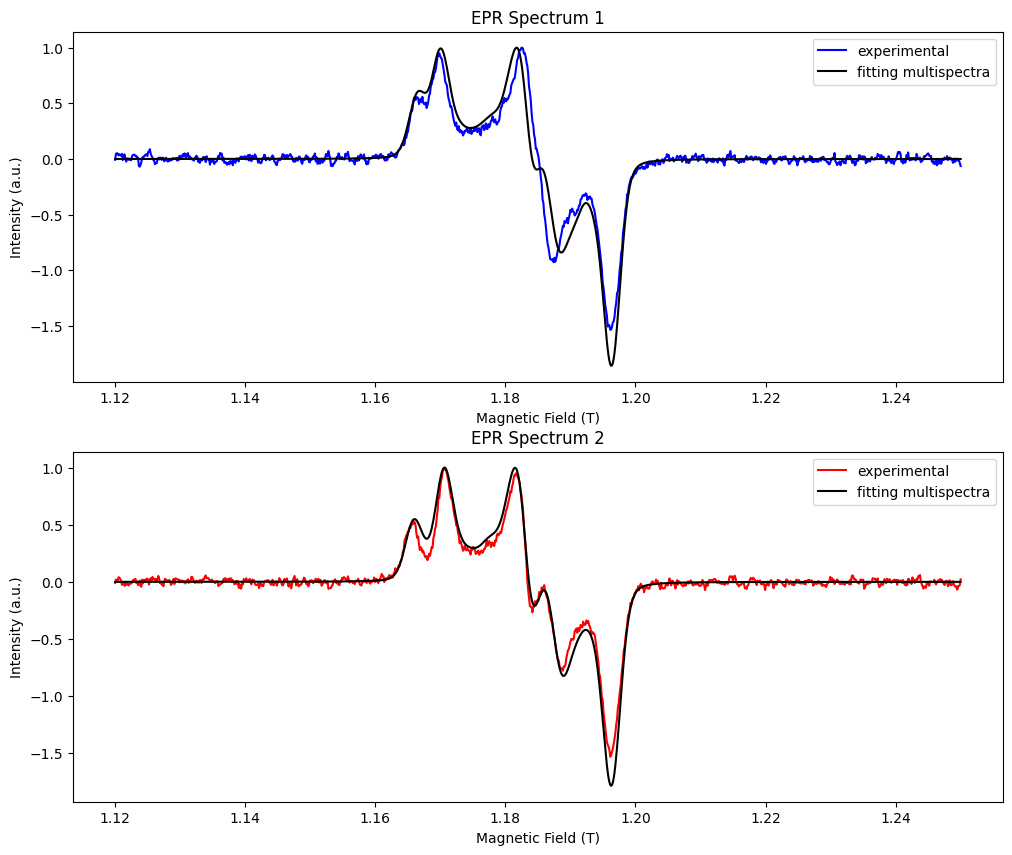

In [37]:
best_spectrum_0 = result_Cobyla_tot.best_spectrum[0].numpy()
best_spectrum_0 = best_spectrum_0 / max(best_spectrum_0)

best_spectrum_1 = result_Cobyla_tot.best_spectrum[1].numpy()
best_spectrum_1 = best_spectrum_1 / max(best_spectrum_1)

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(fields1, spectrum1 / max(spectrum1), 'b-', linewidth=1.5, label="experimental")
plt.plot(fields1, best_spectrum_0, 'black', linewidth=1.5, label="fitting multispectra")
plt.title('EPR Spectrum 1', fontsize=12)
plt.xlabel('Magnetic Field (T)', fontsize=10)
plt.ylabel('Intensity (a.u.)', fontsize=10)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(fields2, spectrum2 / max(spectrum2), 'r-', linewidth=1.5, label="experimental")
plt.plot(fields2, best_spectrum_1, 'black', linewidth=1.5, label="fitting multispectra")
plt.title('EPR Spectrum 2', fontsize=12)
plt.xlabel('Magnetic Field (T)', fontsize=10)
plt.ylabel('Intensity (a.u.)', fontsize=10)
plt.legend()

plt.show()